<a href="https://colab.research.google.com/github/Datangels/Machine_Learning_with_PySpark/blob/master/pyspark_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Google Colab configuration & creation the SparkSession Object**

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## **Define useful functions**

In [0]:
# USeful function to compute correlation matrix

from pyspark.mllib.stat import Statistics
import pandas as pd

# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

def remove_null_from_column(df, column):
    return df.filter(df[column].isNotNull())

## **Read the Dataset**

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dataset_not_clean = spark.read.csv('/content/drive/My Drive/pycharm_colab_training/dataset/fifa19.csv',inferSchema=True, header=True)

## **Exploratory Data Analysis**


In [0]:
# dataset_not_clean.printSchema()
# print((dataset_not_clean.count(), len(dataset_not_clean.columns)))
dataset_not_clean.describe().show(3,False)

+-------+-----------------+------------------+-----+------------------+-----+-----------+-----+-----------------+-----------------+-----+---------+-----+-----+------------------+--------------+------------------------+------------------+------------------+---------+---------+---------+--------+------------------+------+-----------+--------------------+------+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+-------

## **Clean the dataset**

In [0]:
# Select only certains columns
dataset_not_clean_good_columns = dataset_not_clean.select('Age', 'Overall',	'Potential', 'Crossing',	\
                                                          'Finishing',	'HeadingAccuracy',	'ShortPassing',\
                                                          'Volleys',	'Dribbling',	'Curve',	'FKAccuracy',\
                                                          'LongPassing',	'BallControl',	'Acceleration',	 \
                                                          'SprintSpeed',	'Agility',	'Reactions',	'Balance',\
                                                          'ShotPower',	'Jumping',	'Stamina',	'Strength',	'LongShots',\
                                                          'Aggression',	'Interceptions',	'Positioning',\
                                                          'Vision',	'Penalties',	'Composure',	'Marking')

dataset_clean = dataset_not_clean_good_columns
for i in dataset_not_clean_good_columns.columns:
  dataset_clean = remove_null_from_column(dataset_clean, i)

## **Plot correlation matrix**

In [0]:
compute_correlation_matrix(dataset_clean)

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking
Age,1.000000,0.453069,-0.252281,0.130545,0.068660,0.147183,0.132894,0.142472,0.010166,0.143276,0.193467,0.181310,0.084969,-0.158667,-0.151682,-0.019395,0.453124,-0.089877,0.156947,0.177167,0.097793,0.332798,0.155096,0.265190,0.197845,0.082443,0.187422,0.139535,0.391023,0.142817
Overall,0.453069,1.000000,0.661180,0.394972,0.332515,0.340776,0.502550,0.391338,0.372426,0.419491,0.396892,0.483909,0.460197,0.196869,0.210647,0.264952,0.850045,0.103160,0.441118,0.264435,0.365656,0.349326,0.420795,0.395470,0.321326,0.356493,0.498894,0.341429,0.727655,0.286505
Potential,-0.252281,0.661180,1.000000,0.246319,0.243355,0.200988,0.369189,0.254906,0.315019,0.279944,0.230544,0.321437,0.354396,0.234608,0.236771,0.222310,0.513425,0.138025,0.288318,0.109151,0.202563,0.075769,0.266740,0.171174,0.154908,0.245616,0.348141,0.224281,0.440008,0.162801
Crossing,0.130545,0.394972,0.246319,1.000000,0.655300,0.469507,0.809660,0.690339,0.856647,0.833105,0.761107,0.756527,0.840916,0.668365,0.645578,0.698320,0.389574,0.618280,0.705503,0.135486,0.672633,-0.029403,0.742065,0.473570,0.427739,0.783185,0.684948,0.645805,0.575446,0.443101
Finishing,0.068660,0.332515,0.243355,0.655300,1.000000,0.473427,0.661830,0.882675,0.824337,0.759229,0.697550,0.512806,0.788376,0.606378,0.593864,0.644273,0.331376,0.523787,0.815472,0.097464,0.510891,-0.009744,0.877834,0.242825,-0.020703,0.888790,0.697290,0.837827,0.533414,0.024218
HeadingAccuracy,0.147183,0.340776,0.200988,0.469507,0.473427,1.000000,0.640091,0.505639,0.550750,0.440846,0.407772,0.510779,0.658175,0.329647,0.379453,0.260514,0.325867,0.168834,0.611736,0.380041,0.634589,0.486903,0.506814,0.692847,0.548689,0.533818,0.275673,0.551978,0.507208,0.583123
ShortPassing,0.132894,0.502550,0.369189,0.809660,0.661830,0.640091,1.000000,0.698309,0.843722,0.775398,0.736659,0.895722,0.911451,0.565752,0.554681,0.612899,0.483028,0.533126,0.771845,0.197535,0.716659,0.133831,0.761750,0.611570,0.543350,0.757776,0.713524,0.676063,0.685137,0.559576
Volleys,0.142472,0.391338,0.254906,0.690339,0.882675,0.505639,0.698309,1.000000,0.809639,0.807285,0.749637,0.571050,0.794935,0.572064,0.556955,0.624995,0.393713,0.513682,0.832479,0.126228,0.527395,0.029505,0.868253,0.330116,0.088385,0.848333,0.699471,0.829257,0.595281,0.120919
Dribbling,0.010166,0.372426,0.315019,0.856647,0.824337,0.550750,0.843722,0.809639,1.000000,0.842652,0.753600,0.722465,0.938942,0.748292,0.726835,0.765153,0.369265,0.663086,0.804732,0.143079,0.686511,-0.033550,0.843619,0.441075,0.296020,0.896932,0.730150,0.769594,0.597498,0.336072
Curve,0.143276,0.419491,0.279944,0.833105,0.759229,0.440846,0.775398,0.807285,0.842652,1.000000,0.861277,0.710807,0.829568,0.607239,0.578628,0.682104,0.413413,0.586969,0.792143,0.111934,0.590381,-0.035587,0.835309,0.399332,0.273756,0.811082,0.744774,0.751833,0.616532,0.289529


## **Lineplot of useful features compared with Potential**


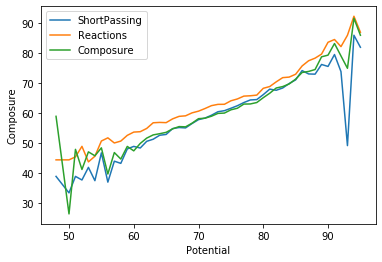

In [0]:
dataset_clean_pd = dataset_clean.toPandas()
sns.lineplot(x="Potential", y="ShortPassing",data=dataset_clean_pd,label="ShortPassing", ci= None)
sns.lineplot(x="Potential", y="Reactions",data=dataset_clean_pd,label="Reactions", ci= None)
sns.lineplot(x="Potential", y="Composure",data=dataset_clean_pd,label="Composure", ci= None)

## **Feature Engineering**

In [0]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=['Age', 'Reactions', 'BallControl', 'HeadingAccuracy', 'ShortPassing'], outputCol='features')
features_df = vec_assembler.transform(dataset_clean)
model_df = features_df.select('features','Potential')

## **Splitting the Dataset**

In [0]:
train_df, test_df = model_df.randomSplit([0.7,0.3])
print("whole dataset: " + str(model_df.count()))
print("train_df dataset: " + str(train_df.count()))
print("test_df dataset: " + str(test_df.count()))

whole dataset: 18159
train_df dataset: 12810
test_df dataset: 5349


## **Build and Train Linear Regression Mode**

> Indented block



In [0]:
from pyspark.ml.regression import LinearRegression
lin_Reg = LinearRegression(labelCol='Potential')
lr_model = lin_Reg.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients)) # Coefficients are the values that multiply the predictor values, y = 3X + 5 where 3 is the coefficient
print("Intercept: " + str(lr_model.intercept)) # Expected mean value of Y when all X=0.

Coefficients: [-0.7891160549415682,0.5031836022915679,-0.010217187733336493,-0.002002026415163144,0.05256025774766755]
Intercept: 57.63247487115995


In [0]:
training_predictions = lr_model.evaluate(train_df)
print("R2: " + str(training_predictions.r2)) # Measures the proportion of variability, how well future outcomes are likely to be predicted, higer the better
print("RMSE: " + str(training_predictions.rootMeanSquaredError)) # Standard deviation of the residuals (prediction errors)
print("MSE: " + str(training_predictions.meanSquaredError)) # Measures the average of the squares of the errors

R2: 0.5689859233708094
RMSE: 4.043398944869239
MSE: 16.349075027369675


## **Evaluate Linear Regression Model on Test Data**

In [0]:
test_results = lr_model.evaluate(test_df)
print("R2: " + str(test_results.r2))
print("RMSE: " + str(test_results.rootMeanSquaredError))
print("MSE: " + str(test_results.meanSquaredError))

R2: 0.5586661548376575
RMSE: 4.035527970517645
MSE: 16.28548600083026


In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction", "Potential", "features").show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Potential",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+---------+--------------------+
|       prediction|Potential|            features|
+-----------------+---------+--------------------+
|72.01909463218348|       83|[17.0,51.0,62.0,5...|
|73.23066353663936|       85|[17.0,53.0,67.0,3...|
|73.47544658764122|       77|[17.0,53.0,67.0,4...|
|73.76364075692493|       77|[17.0,54.0,39.0,5...|
|74.37257562787957|       83|[17.0,55.0,70.0,5...|
+-----------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.558666


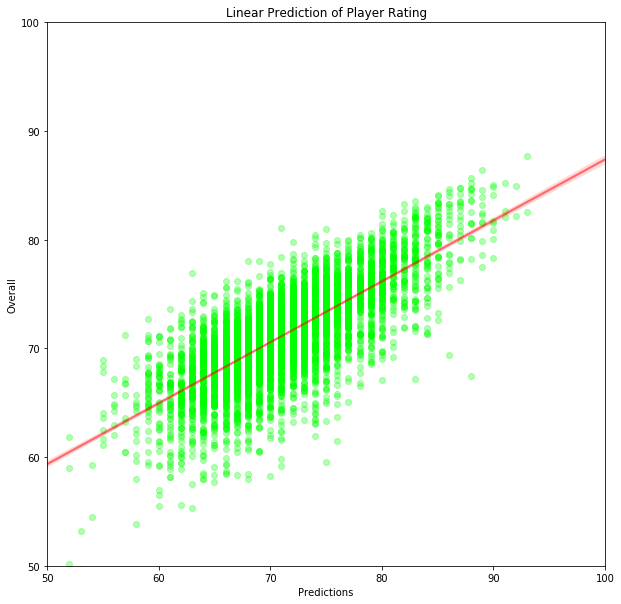

In [0]:
x_data = [row[0] for row in lr_predictions.select('Potential').collect()]
y_data = [row[0] for row in lr_predictions.select('prediction').collect()]

plt.figure(figsize=(10,10))
plt.axis((50,100,50,100))
sns.regplot(
    x_data,
    y_data,
    scatter_kws={'alpha':0.3,'color':'lime'},
    line_kws={'color':'red','alpha':0.5})
plt.xlabel('Predictions')
plt.ylabel('Overall')
plt.title("Linear Prediction of Player Rating")
plt.show()